This is a Jupyter notebook for trajectory analysis of a Hexaglide manipulator

## 1. Code for inverse kinematics (IK) and forward kinematics (FK) calculation according to Palpacelli et al. (2020)

Imports

In [1]:
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from sklearn import preprocessing
from planner import *
import math as m

IK solver

In [2]:
class IKSolver:
    def __init__(self):
        self.init_rotation_matrix = np.eye(3, 3, dtype=float)
        self.init_translation_vector = np.array([0.0, 0.0, 278.256])
        self.init_translation_vector = self.init_translation_vector / 1000
        # self.init_translation_vector = np.array([0.0, 0.0, 235.763])
        self.init_T_1_0 = self.get_transform_matrix(self.init_rotation_matrix, self.init_translation_vector)
        self.L = np.array([236.5, 236.5, 236.5, 236.5, 236.5, 236.5]).reshape(-1, 1)
        self.L = self.L / 1000

        self.s1 = np.array([0, 0, 1]).reshape(-1, 1)
        self.s2 = np.array([0, 0, 1]).reshape(-1, 1)
        self.s3 = np.array([0, 0, 1]).reshape(-1, 1)
        self.s4 = np.array([0, 0, 1]).reshape(-1, 1)
        self.s5 = np.array([0, 0, 1]).reshape(-1, 1)
        self.s6 = np.array([0, 0, 1]).reshape(-1, 1)
        self.s_i = np.concatenate((self.s1, self.s2, self.s3, self.s4, self.s5, self.s6), axis=1)

        self.S_0_1 = np.array([47.040, 104.524, 43.500]).reshape(-1, 1)
        self.S_0_2 = np.array([114.040, -11.524, 43.500]).reshape(-1, 1)
        self.S_0_3 = np.array([67.000, -93.000, 43.500]).reshape(-1, 1)
        self.S_0_4 = np.array([-67.000, -93.000, 43.500]).reshape(-1, 1)
        self.S_0_5 = np.array([-114.040, -11.524, 43.500]).reshape(-1, 1)
        self.S_0_6 = np.array([-47.040, 104.524, 43.500]).reshape(-1, 1)
        self.init_S_0 = np.concatenate((self.S_0_1, self.S_0_2, self.S_0_3, self.S_0_4, self.S_0_5, self.S_0_6), axis=1)
        self.init_S_0 = self.init_S_0 / 1000

        self.P_1_1 = np.array([20.000, 95.000, 0.000]).reshape(-1, 1)
        self.P_1_2 = np.array([92.272, -30.179, 0.000]).reshape(-1, 1)
        self.P_1_3 = np.array([72.272, -64.821, 0.000]).reshape(-1, 1)
        self.P_1_4 = np.array([-72.272, -64.821, 0.000]).reshape(-1, 1)
        self.P_1_5 = np.array([-92.272, -30.179, 0.000]).reshape(-1, 1)
        self.P_1_6 = np.array([-20.000, 95.000, 0.000]).reshape(-1, 1)
        self.init_P_1 = np.concatenate((self.P_1_1, self.P_1_2, self.P_1_3, self.P_1_4, self.P_1_5, self.P_1_6), axis=1)
        self.init_P_1 = self.init_P_1 / 1000

        self.P_0_1 = self.transform_1_0(self.init_T_1_0, self.P_1_1)
        self.P_0_2 = self.transform_1_0(self.init_T_1_0, self.P_1_2)
        self.P_0_3 = self.transform_1_0(self.init_T_1_0, self.P_1_3)
        self.P_0_4 = self.transform_1_0(self.init_T_1_0, self.P_1_4)
        self.P_0_5 = self.transform_1_0(self.init_T_1_0, self.P_1_5)
        self.P_0_6 = self.transform_1_0(self.init_T_1_0, self.P_1_6)
        self.init_P_0 = np.concatenate((self.P_0_1, self.P_0_2, self.P_0_3, self.P_0_4, self.P_0_5, self.P_0_6), axis=1)
        self.init_P_0 = np.resize(self.init_P_0, (3, self.init_P_0.shape[1]))

    @staticmethod
    def get_transform_matrix(rotation_matrix, translation_vector):
        translation_vector = np.reshape(translation_vector, (3, 1))
        transform = np.concatenate((rotation_matrix, translation_vector), axis=1)
        transform = np.concatenate((transform, np.array([[0, 0, 0, 1]])))
        return transform

    @staticmethod
    def transform_1_0(T_1_0, T):
        if T.shape[0] < 4:
            T = np.concatenate((T, (np.array([1]).reshape(-1, 1))))
        transform = np.matmul(T_1_0, T)
        return transform

    def calc_S(self, q):
        S = np.zeros(self.init_S_0.shape)
        S = self.init_S_0 + q.T * self.s_i
        return S

    def calc_q(self, pose, rot, P):
        pose = pose.reshape(-1, 1)
        a = pose + np.matmul(rot, P) - self.init_S_0
        q1 = []
        q2 = []
        for i in range(6):
            q1.append(np.matmul(self.s_i[:, i].T, a[:, i]) +
                      np.sqrt(np.power(np.matmul(self.s_i[:, i].T, a[:, i]), 2) -
                              np.matmul(a[:, i].T, a[:, i]) +
                              np.power(self.L[i], 2)))
            q2.append(np.matmul(self.s_i[:, i].T, a[:, i]) -
                      np.sqrt(np.power(np.matmul(self.s_i[:, i].T, a[:, i]), 2) -
                              np.matmul(a[:, i].T, a[:, i]) +
                              np.power(self.L[i], 2)))
        q1 = np.array(q1, dtype=np.double)
        q2 = np.array(q2, dtype=np.double)
        return q1, q2

    def discretize(self, delta_x, T, polynomial=False, step_size=1, skip_ik=False):
        '''
        Takes a smooth linear trajectory in task space and returns corresponding joint trajectories
        '''
        x = []
        q1 = []
        q2 = []
        delta_x = np.array(delta_x)
        for i, t in enumerate(range(0, T, step_size)):
            z = float(t / T)
            # x.append(((-20.0*z**7)+(70.0*z**6)-(84.0*z**5)+(35.0*z**4))*delta_x)
            if polynomial:
                x.append((((3 * z ** 2) - (2 * z ** 3)) * delta_x))  # Cubic Polynomial
            else:
                x.append(z*delta_x)

            if not skip_ik:
                pose_1 = np.array([x[i][0], x[i][1], x[i][2]]).reshape(-1, 1)
                rx = R.from_euler('x', x[i][3], degrees=True)
                ry = R.from_euler('y', x[i][4], degrees=True)
                rz = R.from_euler('z', x[i][5], degrees=True)
                r = rz * ry * rx
                rot = r.as_matrix()
                transform = self.get_transform_matrix(rot, pose_1)
                T_1_0 = self.transform_1_0(self.init_T_1_0, transform)
                pose_0 = T_1_0[:, -1][:3]
                q1_temp, q2_temp = self.calc_q(pose_0, rot, self.init_P_1)
                q1.append(q1_temp)
                q2.append(q2_temp)
        x = np.array(x)
        q1 = np.array(q1)
        q2 = np.array(q2)
        return x, q1, q2
    
    def smooth_joint_trajectory(self, q_e, T, polynomial=True, step_size=1):
        q = []
        q_e = np.array(q_e)
        for i, t in enumerate(range(0, T, step_size)):
            z = float(t / T)
            if polynomial:
                q.append((((3 * z ** 2) - (2 * z ** 3)) * q_e))  # Cubic Polynomial
            else:
                q.append(z * q_e)
        q = np.array(q)
        return q
    
    def smooth_joint_trajectory_nonzero_start(self, q_0, q_e, T, polynomial=True, step_size=1):
        q = []
        q_0 = np.array(q_0)
        q_e = np.array(q_e)
        for i, t in enumerate(range(0, T, step_size)):
            z = float(t / T)
            if polynomial:
                q.append((q_0 + ((3 * z ** 2) - (2 * z ** 3)) * (q_e - q_0)))  # Cubic Polynomial
            else:
                q.append(q_0 + z * (q_e - q_0))
        q = np.array(q)
        return q
    
    def equal_velocity_joint_trajectory(self, q_e, T):
        q = []
        q_e = np.array(q_e)
        q_e_max = np.max(np.abs(q_e))
        q_vel_max = q_e_max / T
        delta_q = q_vel_max
        q_curr = np.zeros((6,1), dtype=np.float32)
        for t in range(0, T):
            for i in range(6):
                if q_e[i][0] >= 0.0:
                    if q_curr[i] + delta_q < q_e[i][0]:
                        q_curr[i] = q_curr[i] + delta_q
                    else:
                        q_curr[i] = q_e[i][0]
                else:
                    if q_curr[i] - delta_q > q_e[i][0]:
                        q_curr[i] = q_curr[i] - delta_q
                    else:
                        q_curr[i] = q_e[i][0]
            q.append(q_curr * 1.0)
        q = np.array(q)
        return q

    @staticmethod
    def forward_derivative(fx, step_size=1):
        np.array(fx)
        fx_diff = []
        for i in (range(len(fx) - 1)):
            fx_diff.append((np.subtract(fx[i + 1], fx[i]) / step_size))
        return np.array(fx_diff)

FK solver

In [3]:
class FKSolver(IKSolver):
    def __init__(self):
        super().__init__()
        self.x0 = None
        self.x1 = None
        self.x2 = None
        self.x3 = None
        self.y0 = None
        self.y1 = None
        self.y2 = None
        self.y3 = None
        self.x = np.zeros(8)
        self.e = [None, None, None, None, None, None]
        self.s = None
        self.n = None
        self.constraints = np.zeros(8)
        self.constraint_tolerance = 1e-8

    def update_study_params(self, transform=None):
        if transform is None:
            T = self.init_T_1_0
        else:
            T = transform
        self.x3 = 0.5 * np.sqrt(T[0, 0] + T[1, 1] + T[2, 2] + 1)
        self.x0 = (T[2, 1] - T[1, 2]) / (4 * self.x3)
        self.x1 = (T[0, 2] - T[2, 0]) / (4 * self.x3)
        self.x2 = (T[1, 0] - T[0, 1]) / (4 * self.x3)
        self.y0 = -0.5 * (T[0, 3] * self.x3 + T[1, 3] * self.x2 - T[2, 3] * self.x1)
        self.y1 = -0.5 * (-T[0, 3] * self.x2 + T[1, 3] * self.x3 + T[2, 3] * self.x0)
        self.y2 = -0.5 * (T[0, 3] * self.x1 - T[1, 3] * self.x0 + T[2, 3] * self.x3)
        self.y3 = -0.5 * (T[0, 3] * self.x0 + T[1, 3] * self.x1 + T[2, 3] * self.x2)
        self.x = np.array([self.x0, self.x1, self.x2, self.x3, self.y0, self.y1, self.y2, self.y3])
        # print(self.x)

    def transform_from_study_params(self):
        T = np.zeros((4, 4))
        x0 = self.x[0]
        x1 = self.x[1]
        x2 = self.x[2]
        x3 = self.x[3]
        y0 = self.x[4]
        y1 = self.x[5]
        y2 = self.x[6]
        y3 = self.x[7]

        T[0, 0] = x0 ** 2 - x1 ** 2 - x2 ** 2 + x3 ** 2
        T[0, 1] = 2 * ((x0 * x1) - (x2 * x3))
        T[0, 2] = 2 * ((x0 * x2) + (x1 * x3))
        T[0, 3] = 2 * ((x0 * y3) - (x1 * y2) + (x2 * y1) - (x3 * y0))

        T[1, 0] = 2 * ((x0 * x1) + (x2 * x3))
        T[1, 1] = -x0 ** 2 + x1 ** 2 - x2 ** 2 + x3 ** 2
        T[1, 2] = 2 * ((x1 * x2) - (x0 * x3))
        T[1, 3] = 2 * ((x0 * y2) + (x1 * y3) - (x2 * y0) - (x3 * y1))

        T[2, 0] = 2 * ((x0 * x2) - (x1 * x3))
        T[2, 1] = 2 * ((x1 * x2) + (x0 * x3))
        T[2, 2] = -x0 ** 2 - x1 ** 2 + x2 ** 2 + x3 ** 2
        T[2, 3] = 2 * ((x1 * y0) - (x0 * y1) + (x2 * y3) - (x3 * y2))

        T[3, 0] = 0
        T[3, 1] = 0
        T[3, 2] = 0
        T[3, 3] = x0 ** 2 + x1 ** 2 + x2 ** 2 + x3 ** 2

        return T

    def calc_J(self, P_0, S_0):
        J = np.zeros((8, 8), dtype=np.float64)

        dT_dx0 = np.array([[2 * self.x0, 2 * self.x1, 2 * self.x2, 2 * self.y3],
                           [2 * self.x1, -2 * self.x0, -2 * self.x3, 2 * self.y2],
                           [2 * self.x2, 2 * self.x3, -2 * self.x0, -2 * self.y1],
                           [0, 0, 0, 2 * self.x0]])
        
        dT_dx1 = np.array([[-2 * self.x1, 2 * self.x0, 2 * self.x3, -2 * self.y2],
                           [2 * self.x0, 2 * self.x1, 2 * self.x2, 2 * self.y3],
                           [-2 * self.x3, 2 * self.x2, -2 * self.x1, 2 * self.y0],
                           [0, 0, 0, 2 * self.x1]])
        
        dT_dx2 = np.array([[-2 * self.x2, -2 * self.x3, 2 * self.x0, 2 * self.y1],
                           [2 * self.x3, -2 * self.x2, 2 * self.x1, -2 * self.y0],
                           [2 * self.x0, 2 * self.x1, 2 * self.x2, 2 * self.y3],
                           [0, 0, 0, 2 * self.x2]])
        
        dT_dx3 = np.array([[2 * self.x3, -2 * self.x2, 2 * self.x1, -2 * self.y0],
                           [2 * self.x2, 2 * self.x3, -2 * self.x0, -2 * self.y1],
                           [-2 * self.x1, 2 * self.x0, 2 * self.x3, -2 * self.y2],
                           [0, 0, 0, 2 * self.x3]])
        
        dT_dy0 = np.array([[0, 0, 0, -2 * self.x3],
                           [0, 0, 0, -2 * self.x2],
                           [0, 0, 0, 2 * self.x1],
                           [0, 0, 0, 0]])
        
        dT_dy1 = np.array([[0, 0, 0, 2 * self.x2],
                           [0, 0, 0, -2 * self.x3],
                           [0, 0, 0, -2 * self.x0],
                           [0, 0, 0, 0]])
        
        dT_dy2 = np.array([[0, 0, 0, -2 * self.x1],
                           [0, 0, 0, 2 * self.x0],
                           [0, 0, 0, -2 * self.x3],
                           [0, 0, 0, 0]])
        
        dT_dy3 = np.array([[0, 0, 0, 2 * self.x0],
                           [0, 0, 0, 2 * self.x1],
                           [0, 0, 0, 2 * self.x2],
                           [0, 0, 0, 0]])
        
        dT_dx = [dT_dx0, dT_dx1, dT_dx2, dT_dx3, dT_dy0, dT_dy1, dT_dy2, dT_dy3]
        ds_dx = [self.y0, self.y1, self.y2, self.y3, self.x0, self.x1, self.x2, self.x3]
        dn_dx = [2 * self.x0, 2 * self.x1, 2 * self.x2, 2 * self.x3, 0, 0, 0, 0]

        # Iterate over 8 study parameters
        for i in range(np.shape(J)[1]):
            # Iterate over 6 e_j constraints
            for j in range(np.shape(P_0)[1]):
                dP_dx = self.transform_1_0(dT_dx[i], P_0[:, j].reshape(-1, 1))
                dP_dx = np.resize(dP_dx, (3, dP_dx.shape[1]))
                J[j, i] = np.vdot(2 * (P_0[:, j] - S_0[:, j]), dP_dx)
            # s constraint
            J[j + 1, i] = ds_dx[i]
            # n constraint
            J[j + 2, i] = dn_dx[i]
        return J

    def update_constraints(self, P_0, S_0):
        temp_P = P_0
        temp_S = S_0
        e1 = (np.linalg.norm(np.subtract(P_0[:, 0], S_0[:, 0])) ** 2 - self.L[0] ** 2)[0]
        e2 = (np.linalg.norm(np.subtract(P_0[:, 1], S_0[:, 1])) ** 2 - self.L[1] ** 2)[0]
        e3 = (np.linalg.norm(np.subtract(P_0[:, 2], S_0[:, 2])) ** 2 - self.L[2] ** 2)[0]
        e4 = (np.linalg.norm(np.subtract(P_0[:, 3], S_0[:, 3])) ** 2 - self.L[3] ** 2)[0]
        e5 = (np.linalg.norm(np.subtract(P_0[:, 4], S_0[:, 4])) ** 2 - self.L[4] ** 2)[0]
        e6 = (np.linalg.norm(np.subtract(P_0[:, 5], S_0[:, 5])) ** 2 - self.L[5] ** 2)[0]
        s = self.x0 * self.y0 + self.x1 * self.y1 + self.x2 * self.y2 + self.x3 * self.y3
        n = self.x0 ** 2 + self.x1 ** 2 + self.x2 ** 2 + self.x3 ** 2 - 1
        self.constraints = np.array([e1, e2, e3, e4, e5, e6, s, n])

    def check_constraints(self):
        constraint_status = [False, False, False, False, False, False, False, False]
        for i in range(len(self.constraints)):
            constraint_status[i] = True if abs(self.constraints[i]) <= self.constraint_tolerance else False
        return constraint_status

    def get_eef_transform_matrix(self, init_T_1_0, q_i, q_curr, n_iter=100, n_q=10):
        q = np.linspace(q_i, q_curr, n_q)
        T = init_T_1_0
        init_P_0_1 = self.transform_1_0(T, self.P_1_1 / 1000)
        init_P_0_2 = self.transform_1_0(T, self.P_1_2 / 1000)
        init_P_0_3 = self.transform_1_0(T, self.P_1_3 / 1000)
        init_P_0_4 = self.transform_1_0(T, self.P_1_4 / 1000)
        init_P_0_5 = self.transform_1_0(T, self.P_1_5 / 1000)
        init_P_0_6 = self.transform_1_0(T, self.P_1_6 / 1000)
        P_0 = np.concatenate((init_P_0_1, init_P_0_2, init_P_0_3, init_P_0_4, init_P_0_5, init_P_0_6), axis=1)
        P_0 = np.resize(P_0, (3, P_0.shape[1]))
        S_0 = self.calc_S(q[0])

        self.update_study_params(T)

        self.update_constraints(P_0, S_0)

        J = self.calc_J(P_0, S_0)
        self.x = self.x - np.matmul(np.linalg.inv(J), self.constraints)

        #T = np.around(self.transform_from_study_params(), decimals=5)
        T = self.transform_from_study_params()

        for k in range(1, np.shape(q)[0]):
            for i in range(n_iter):
                init_P_0_1 = self.transform_1_0(T, self.P_1_1 / 1000)
                init_P_0_2 = self.transform_1_0(T, self.P_1_2 / 1000)
                init_P_0_3 = self.transform_1_0(T, self.P_1_3 / 1000)
                init_P_0_4 = self.transform_1_0(T, self.P_1_4 / 1000)
                init_P_0_5 = self.transform_1_0(T, self.P_1_5 / 1000)
                init_P_0_6 = self.transform_1_0(T, self.P_1_6 / 1000)
                P_0 = np.concatenate((init_P_0_1, init_P_0_2, init_P_0_3, init_P_0_4, init_P_0_5, init_P_0_6), axis=1)
                P_0 = np.resize(P_0, (3, P_0.shape[1]))
                S_0 = self.calc_S(q[k])

                self.update_study_params(T)

                self.update_constraints(P_0, S_0)
                constraints_flag = self.check_constraints()
                
                if all(constraints_flag):
                    #print('All constraints satisfied in ' + str(i) + ' iterations')
                    T = self.transform_from_study_params()
                    break
                else:
                    J = self.calc_J(P_0, S_0)
                    self.x = self.x - np.matmul(np.linalg.inv(J), self.constraints)
                    T = self.transform_from_study_params()
                
                #if i == n_iter - 1:
                #    print(f'Warning: constraint tolerance not reached within {n_iter} iterations at k={k}!')
                    
        return T

Pose trajectory plotter

In [4]:
def plot_pose_trajectories(x, T, save_plot=False, ignore_rotations=False):
    """
    Plot translation and rotation trajectories in a 3x2 subplot layout.
    
    Args:
        x: Array of shape (T,6) containing translations (x,y,z) and rotations (rx,ry,rz)
        T: Number of timesteps
        save_plot: Whether to save plot to file (default: False)
    """
    fig, axs = plt.subplots(3, 2, figsize=(10,8), sharex='col')
    time = range(T)
    translations = x[:,:3] * 1000
    if ignore_rotations:
        rotations = np.zeros(translations.shape)
    else:
        rotations = x[:,3:]

    # Get axis limits for sharing with 10% padding
    trans_min = np.min(translations)
    trans_max = np.max(translations)
    trans_range = trans_max - trans_min
    trans_pad = 0.1 * trans_range
    trans_min -= trans_pad
    trans_max += trans_pad

    rot_min = np.min(rotations)
    rot_max = np.max(rotations)
    rot_range = rot_max - rot_min
    rot_pad = 0.1 * rot_range
    rot_min -= rot_pad
    rot_max += rot_pad

    # Translation plots
    labels = ['x', 'y', 'z']
    for i in range(3):
        axs[i,0].plot(time, translations[:,i], 'b-')
        axs[i,0].set_ylim(trans_min, trans_max)
        axs[i,0].set_ylabel(f'{labels[i]} [mm]', rotation=0, ha='right')
        axs[i,0].grid(True, axis='y', linestyle='--', alpha=0.3)
        axs[i,0].axhline(y=0, color='k', linestyle='-', alpha=0.1)
        
        if i < 2:
            axs[i,0].set_xticklabels([])

    # Rotation plots        
    labels = [r'$\theta_x$', r'$\theta_y$', r'$\theta_z$']
    for i in range(3):
        axs[i,1].plot(time, rotations[:,i], 'r-')
        axs[i,1].set_ylim(rot_min, rot_max)
        axs[i,1].set_ylabel(f'{labels[i]} [deg]', rotation=0, ha='right')
        axs[i,1].grid(True, axis='y', linestyle='--', alpha=0.3)
        axs[i,1].axhline(y=0, color='k', linestyle='-', alpha=0.1)
        
        if i < 2:
            axs[i,1].set_xticklabels([])

    # X-axis labels
    axs[2,0].set_xlabel('Timesteps')
    axs[2,1].set_xlabel('Timesteps')

    plt.tight_layout()

Joint trajectory plotter

In [5]:
def plot_joint_trajectories(q, T, save_plot=False):
    """
    Plot joint trajectories in a 3x2 subplot layout.
    
    Args:
        q: Array of shape (T,6) containing joint positions q1-q6
        T: Number of timesteps
        save_plot: Whether to save plot to file (default: False)
    """
    fig, axs = plt.subplots(3, 2, figsize=(10,8), sharex='col')
    time = range(T)
    q = q * 1000 # convert to millimeters
    
    # Get axis limits with 10% padding
    q_min = np.min(q)
    q_max = np.max(q)
    q_range = q_max - q_min
    q_pad = 0.1 * q_range
    q_min -= q_pad
    q_max += q_pad

    # Joint plots
    labels = [r'$q_1$', r'$q_2$', r'$q_3$', r'$q_4$', r'$q_5$', r'$q_6$']
    for i in range(3):
        for j in range(2):
            joint_idx = i*2 + j
            axs[i,j].plot(time, q[:,joint_idx], 'b-')
            axs[i,j].set_ylim(q_min, q_max)
            axs[i,j].set_ylabel(f'{labels[joint_idx]} [mm]', rotation=0, ha='right')
            axs[i,j].grid(True, axis='y', linestyle='--', alpha=0.3)
            axs[i,j].axhline(y=0, color='k', linestyle='-', alpha=0.1)
            
            if i < 2:
                axs[i,j].set_xticklabels([])

    # X-axis labels
    axs[2,0].set_xlabel('Timesteps')
    axs[2,1].set_xlabel('Timesteps') 

    plt.tight_layout()

Pose trajectory comparison plotter

In [6]:
def plot_pose_trajectory_comparison(x, x_other, T, save_plot=False, ignore_rotations=False):
    """
    Plot translation and rotation trajectories in a 3x2 subplot layout.
    
    Args:
        x: Array of shape (T,6) containing translations (x,y,z) and rotations (rx,ry,rz)
        T: Number of timesteps
        save_plot: Whether to save plot to file (default: False)
    """
    fig, axs = plt.subplots(3, 2, figsize=(10,8), sharex='col')
    time = range(T)
    translations = x[:,:3] * 1000
    translations_other = x_other[:,:3] * 1000
    if ignore_rotations:
        rotations = np.zeros(translations.shape)
        rotations_other = np.zeros(translations_other.shape)
    else:
        rotations = x[:,3:]
        rotations_other = x_other[:,3:]

    # Get axis limits for sharing with 10% padding
    trans_min = np.min(np.concatenate((translations, translations_other)))
    trans_max = np.max(np.concatenate((translations, translations_other)))
    trans_range = trans_max - trans_min
    trans_pad = 0.1 * trans_range
    trans_min -= trans_pad
    trans_max += trans_pad

    rot_min = np.min(np.concatenate((rotations, rotations_other)))
    rot_max = np.max(np.concatenate((rotations, rotations_other)))
    rot_range = rot_max - rot_min
    rot_pad = 0.1 * rot_range
    rot_min -= rot_pad
    rot_max += rot_pad

    # Translation plots
    labels = ['x', 'y', 'z']
    for i in range(3):
        axs[i,0].plot(time, translations[:,i], 'b-')
        axs[i,0].plot(time, translations_other[:,i], 'g--')
        axs[i,0].set_ylim(trans_min, trans_max)
        axs[i,0].set_ylabel(f'{labels[i]} [mm]', rotation=0, ha='right')
        axs[i,0].grid(True, axis='y', linestyle='--', alpha=0.3)
        axs[i,0].axhline(y=0, color='k', linestyle='-', alpha=0.1)
        
        if i < 2:
            axs[i,0].set_xticklabels([])

    # Rotation plots        
    labels = [r'$\theta_x$', r'$\theta_y$', r'$\theta_z$']
    for i in range(3):
        axs[i,1].plot(time, rotations[:,i], 'r-')
        axs[i,1].plot(time, rotations_other[:,i], 'k:')
        axs[i,1].set_ylim(rot_min, rot_max)
        axs[i,1].set_ylabel(f'{labels[i]} [deg]', rotation=0, ha='right')
        axs[i,1].grid(True, axis='y', linestyle='--', alpha=0.3)
        axs[i,1].axhline(y=0, color='k', linestyle='-', alpha=0.1)
        
        if i < 2:
            axs[i,1].set_xticklabels([])

    # X-axis labels
    axs[2,0].set_xlabel('Timesteps')
    axs[2,1].set_xlabel('Timesteps')

    plt.tight_layout()

## Experiment zone

Different goal positions (0 rotations) in the xy-plane: 1 mm raster, +/- 50 mm from the origin (100*100=10000 data points)

Heatmaps show:

1) maximum deviation magnitudes
2) x, y, z components of the maximum deviation vector

In [7]:
def plot_heatmap(data, x_label="x [mm]", y_label="y [mm]", title="Heatmap", cmap="viridis", limit=10):
    """
    Plot a 2D NumPy array as a heatmap.

    Args:
        data: 2D NumPy array to be visualized as a heatmap.
        x_label: Label for the x-axis (default: "x [mm]").
        y_label: Label for the y-axis (default: "y [mm]").
        title: Title of the heatmap (default: "Heatmap").
        cmap: Colormap to use for the heatmap (default: "viridis").
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(data, cmap=cmap, aspect='auto', extent=[-limit-0.5, limit+0.5, -limit-0.5, limit+0.5])
    plt.colorbar(label="Value [mm]")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.tight_layout()
    plt.show()

### Bar length error sensitivity (random sampling)

In [8]:
IK = IKSolver()
FK = FKSolver()

step = 5  # mm
limit = 30  # 30 mm used in the paper, set to 0 to skip this calculation

# Bar length sensitivity field (6 values per test position)
L_sens_field = np.zeros((2*limit//step+1, 2*limit//step+1, 6), dtype=np.float32)

# L taken from IK init
L_array_0 = IK.L
L0 = IK.L[0][0]  # m

# Max. component-wise error
dL = 0.1 / 1000  # m

# For matrix indices
i = 0
for x in range(-limit, limit+1, step):  # mm
    j = 0
    for y in range(-limit, limit+1, step):  # mm
        print(f'\nTest position: ({x}, {y}, 0) mm')

        test_pose = [x / 1000.0, y / 1000.0, 0.0, 0.0, 0.0, 0.0]  # change z rotations here
        #print('Test pose:\t', test_pose)

        # Make sure to overwrite any changes to IK config from other iterations
        IK.L = L_array_0
        FK.L = L_array_0

        # Get joint positions using IK (fixed during sampling)
        rx = R.from_euler('x', test_pose[3], degrees=True)
        ry = R.from_euler('y', test_pose[4], degrees=True)
        rz = R.from_euler('z', test_pose[5], degrees=True)
        r = rz * ry * rx
        rot = r.as_matrix()
        #rot = np.eye(3)
        pose_1 = np.array([test_pose[0], test_pose[1], test_pose[2]]).reshape(-1, 1)  # in meters
        transform = IK.get_transform_matrix(rot, pose_1)
        T_1_0 = IK.transform_1_0(IK.init_T_1_0, transform)
        pose_0 = T_1_0[:, -1][:3]
        P = IK.init_P_1

        _, test_joints = IK.calc_q(pose_0, rot, P)

        T_1_0_in = FK.transform_1_0(FK.init_T_1_0, FK.get_transform_matrix(np.eye(3), np.zeros((3,1))))
        q_0 = np.zeros((6, 1), dtype=np.float32)

        z_offset = None

        # Helper variables for max. dev calculation
        max_pose_error = np.zeros(6)

        for n in range(100):  # n_L random error arrays
            L_sample = np.random.uniform(low=L0-dL, high=L0+dL, size=(6,1))
            #print(f'L_sample: {L_sample.T*1000} mm')

            # Set new varied bar lengths as IK and FK attribute
            IK.L = L_sample
            FK.L = L_sample

            # Get resulting EEF pose using FK
            fk = FK.get_eef_transform_matrix(T_1_0_in, q_0, test_joints, n_iter=50, n_q=50)
            x_test = np.zeros(6)
            x_test[:3] = fk[:3, 3]
            if z_offset is None:
               z_offset = x_test[2]
            x_test[2] -= z_offset
            x_test[3:] = R.from_matrix(fk[:3, :3]).as_euler('xyz', degrees=True)
            
            # Get deviation vector
            x_err = x_test - np.array(test_pose)
            #print(f'x_err: {x_err}')

            # See whether some absolute value of the pose error is larger than so far recorded at this test pose
            for k in range(6):
                if np.abs(x_err[k]) > max_pose_error[k]:
                    max_pose_error[k] = np.abs(x_err[k])

        print(f'max_pose_error: {max_pose_error}')

        # Convert to mm, angles remain as degrees
        max_pose_error[0] *= 1000  # mm for better understanding
        max_pose_error[1] *= 1000  # mm for better understanding
        max_pose_error[2] *= 1000  # mm for better understanding

        L_sens_field[j,i,:] = max_pose_error

        j += 1

    i += 1



Test position: (-30, -30, 0) mm
max_pose_error: [8.81222534e-04 9.51710308e-04 1.93220108e-04 7.46784719e-02
 7.11570015e-02 3.37991645e-01]

Test position: (-30, -25, 0) mm
max_pose_error: [7.28245846e-04 7.58290338e-04 1.74111438e-04 7.64069195e-02
 6.19952779e-02 3.84275566e-01]

Test position: (-30, -20, 0) mm
max_pose_error: [7.83776576e-04 7.91376614e-04 1.60076199e-04 6.85560076e-02
 5.89096428e-02 3.38098944e-01]

Test position: (-30, -15, 0) mm
max_pose_error: [7.21313905e-04 8.52358370e-04 2.19391821e-04 7.15775615e-02
 5.70891104e-02 4.14083069e-01]

Test position: (-30, -10, 0) mm
max_pose_error: [8.91075258e-04 6.97090993e-04 1.34214593e-04 6.19547940e-02
 5.74427809e-02 3.34145544e-01]

Test position: (-30, -5, 0) mm
max_pose_error: [7.08708280e-04 7.30482993e-04 1.11905976e-04 7.55078698e-02
 5.84723201e-02 3.87191036e-01]

Test position: (-30, 0, 0) mm
max_pose_error: [8.41032887e-04 7.27987516e-04 1.69803709e-04 7.13159223e-02
 7.35378751e-02 3.27438871e-01]

Test pos

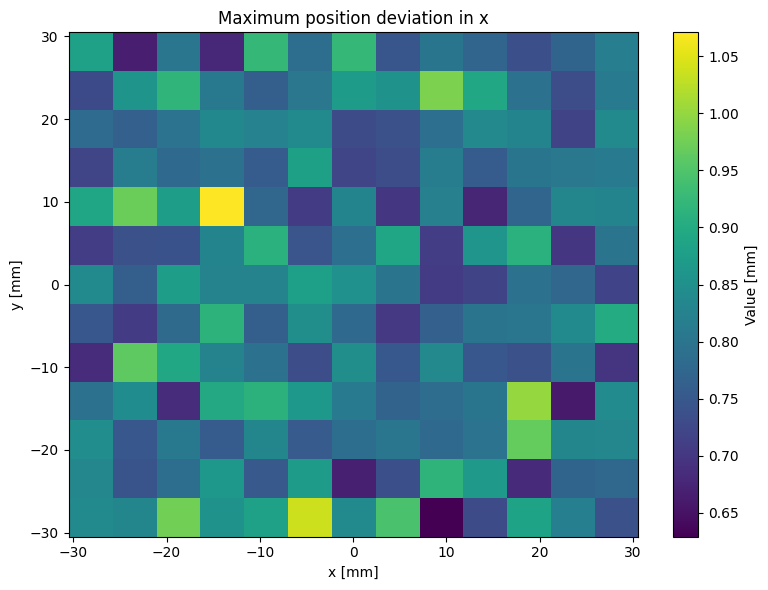

In [9]:
plot_heatmap(L_sens_field[:,:,0], title='Maximum position deviation in x', limit=limit)

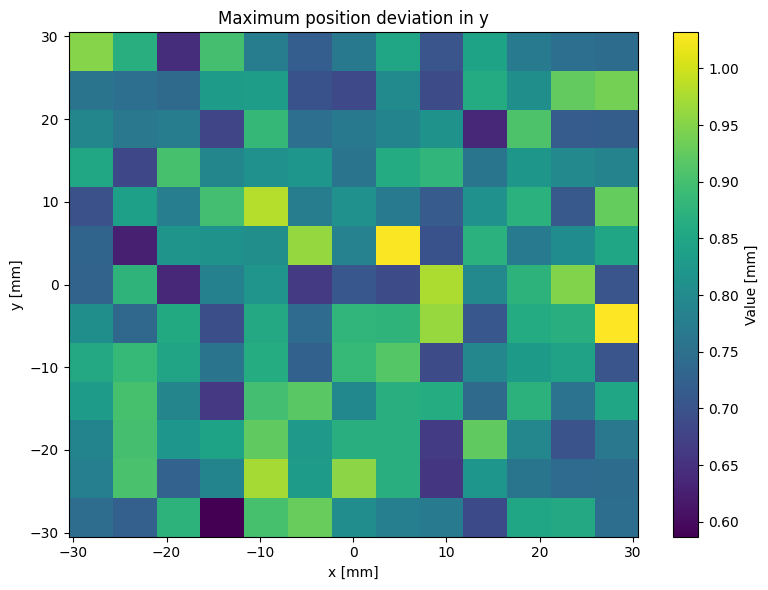

In [10]:
plot_heatmap(L_sens_field[:,:,1], title='Maximum position deviation in y', limit=limit)

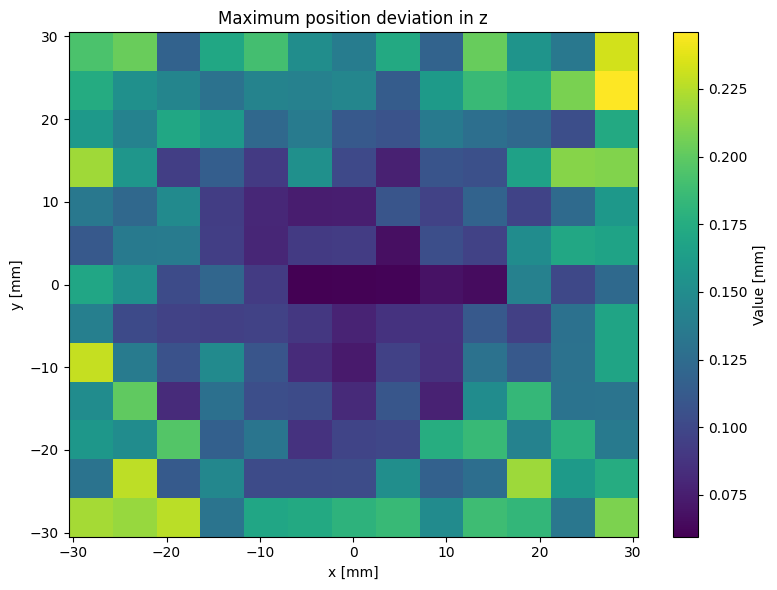

In [11]:
plot_heatmap(L_sens_field[:,:,2], title='Maximum position deviation in z', limit=limit)

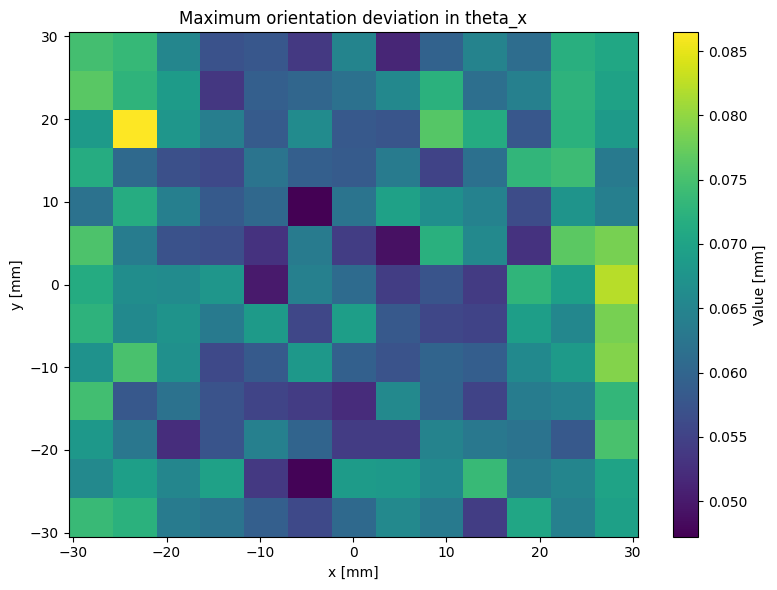

In [12]:
plot_heatmap(L_sens_field[:,:,3], title='Maximum orientation deviation in theta_x', limit=limit)

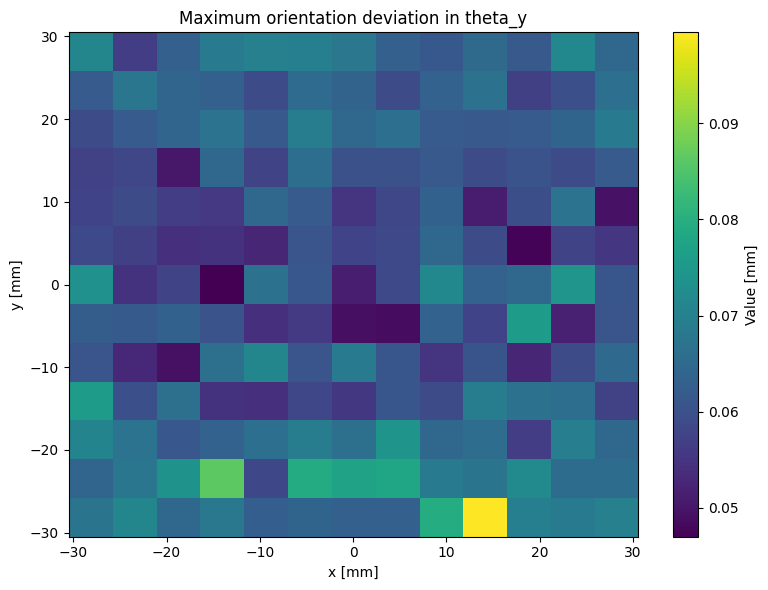

In [13]:
plot_heatmap(L_sens_field[:,:,4], title='Maximum orientation deviation in theta_y', limit=limit)

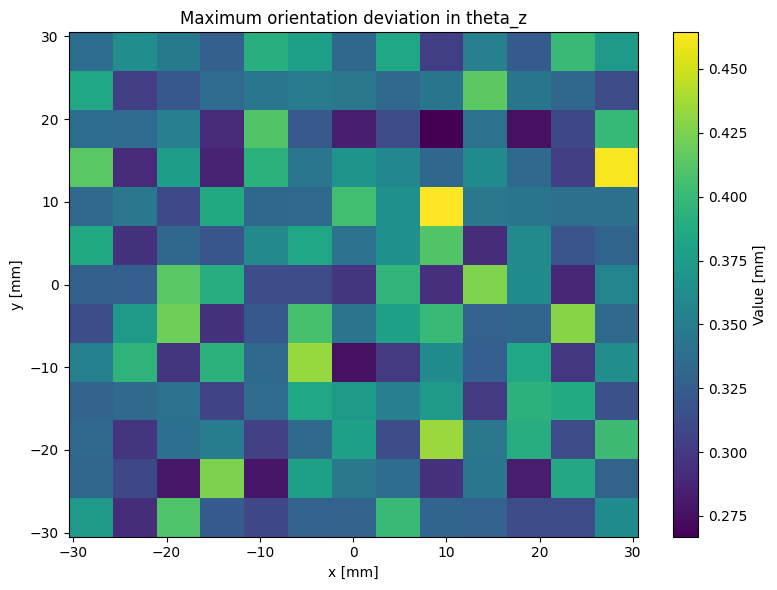

In [14]:
plot_heatmap(L_sens_field[:,:,5], title='Maximum orientation deviation in theta_z', limit=limit)

Some numeric values of statistical properties of the fields above...

In [15]:
np.mean(L_sens_field[:,:,0])

np.float32(0.8064632)

In [16]:
np.std(L_sens_field[:,:,0])

np.float32(0.07630126)

In [17]:
np.mean(L_sens_field[:,:,1])

np.float32(0.80574363)

In [18]:
np.std(L_sens_field[:,:,1])

np.float32(0.08552606)

In [21]:
np.mean(L_sens_field[:,:,2])

np.float32(0.13519068)

In [22]:
np.std(L_sens_field[:,:,2])

np.float32(0.04203723)

In [23]:
np.mean(L_sens_field[:,:,3])

np.float32(0.06393636)

In [24]:
np.std(L_sens_field[:,:,3])

np.float32(0.0073061762)

In [25]:
np.mean(L_sens_field[:,:,4])

np.float32(0.0628884)

In [26]:
np.std(L_sens_field[:,:,4])

np.float32(0.0072053345)

In [27]:
np.mean(L_sens_field[:,:,5])

np.float32(0.3468588)

In [28]:
np.std(L_sens_field[:,:,5])

np.float32(0.04015993)

In [29]:
np.max(L_sens_field[:,:,0])

np.float32(1.0710269)

In [30]:
np.max(L_sens_field[:,:,1])

np.float32(1.0318406)

In [31]:
np.max(L_sens_field[:,:,2])

np.float32(0.2459157)

In [32]:
np.max(L_sens_field[:,:,3])

np.float32(0.08645854)

In [33]:
np.max(L_sens_field[:,:,4])

np.float32(0.09948113)

In [34]:
np.max(L_sens_field[:,:,5])

np.float32(0.46434453)

A histogram may also say a lot. For instance, the distribution should be left-skewed and long-tailed as the fields contain only absolute values of maximum deviations.

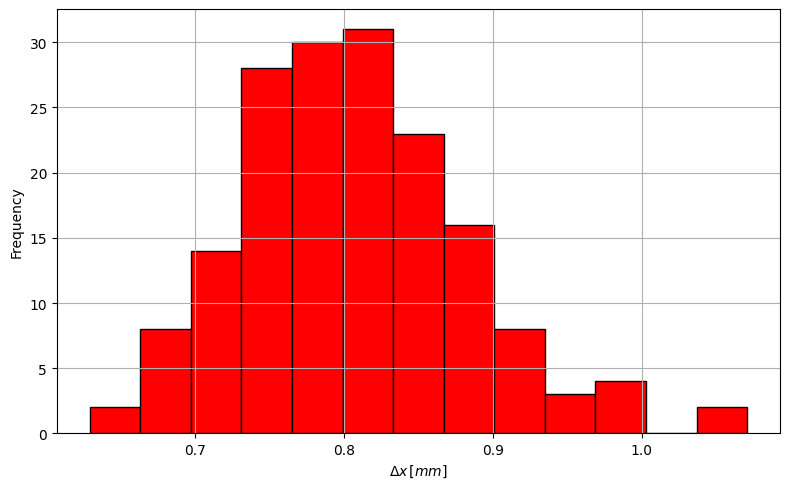

In [35]:
flattened_x = L_sens_field[:,:,0].flatten()

plt.figure(figsize=(8, 5))
plt.hist(flattened_x, bins=13, color='red', edgecolor='black')
plt.xlabel(r'$\Delta x\,[mm]$')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

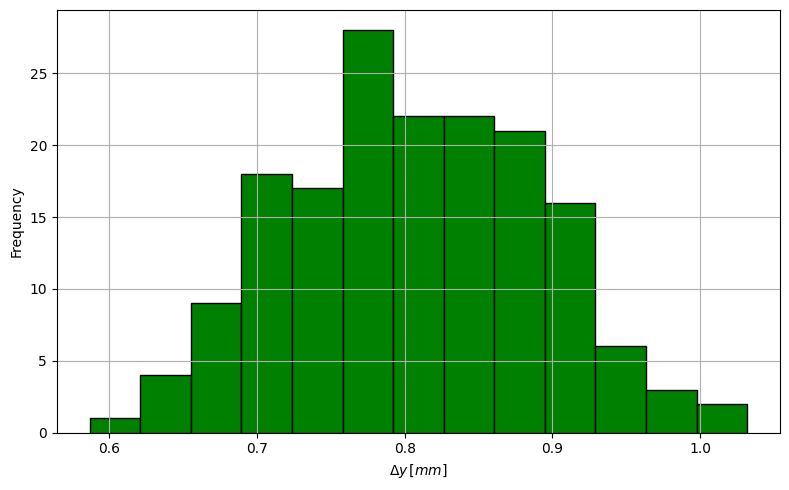

In [36]:
flattened_y = L_sens_field[:,:,1].flatten()

plt.figure(figsize=(8, 5))
plt.hist(flattened_y, bins=13, color='green', edgecolor='black')
plt.xlabel(r'$\Delta y\,[mm]$')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

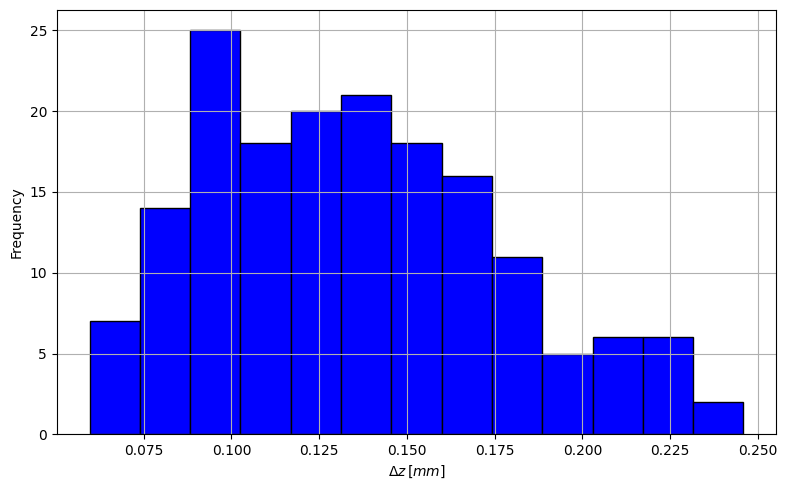

In [37]:
flattened_z = L_sens_field[:,:,2].flatten()

plt.figure(figsize=(8, 5))
plt.hist(flattened_z, bins=13, color='blue', edgecolor='black')
plt.xlabel(r'$\Delta z\,[mm]$')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

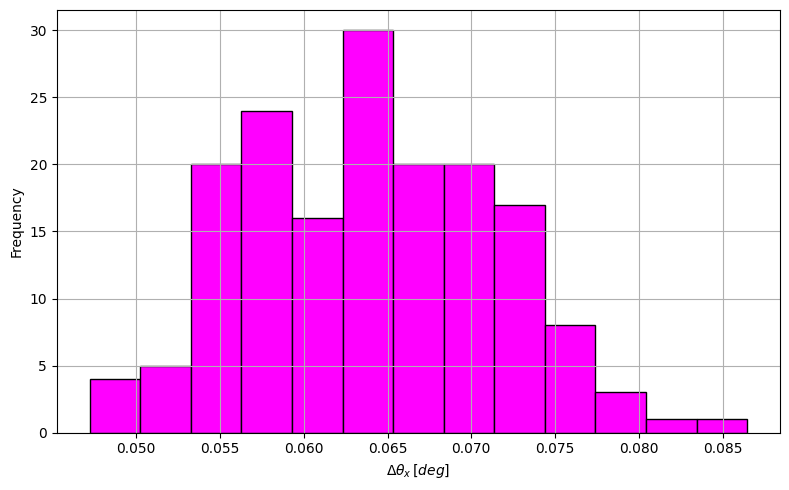

In [38]:
flattened_theta_x = L_sens_field[:,:,3].flatten()

plt.figure(figsize=(8, 5))
plt.hist(flattened_theta_x, bins=13, color='magenta', edgecolor='black')
plt.xlabel(r'$\Delta \theta_x\,[deg]$')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

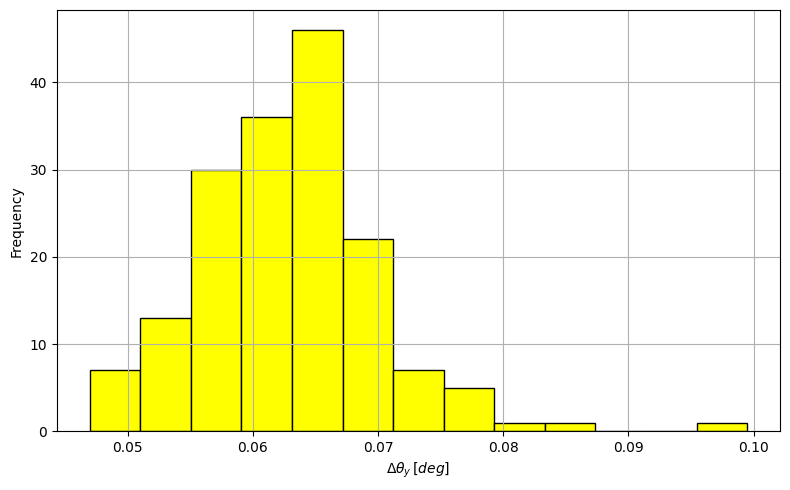

In [39]:
flattened_theta_y = L_sens_field[:,:,4].flatten()

plt.figure(figsize=(8, 5))
plt.hist(flattened_theta_y, bins=13, color='yellow', edgecolor='black')
plt.xlabel(r'$\Delta \theta_y\,[deg]$')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

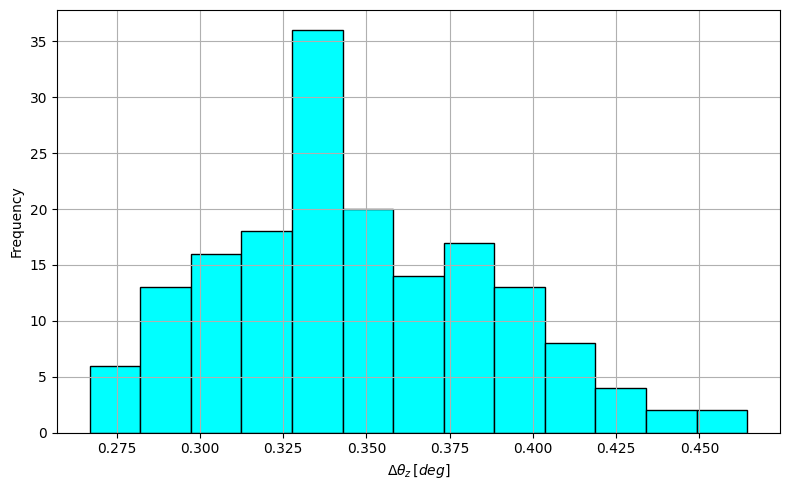

In [40]:
flattened_theta_z = L_sens_field[:,:,5].flatten()

plt.figure(figsize=(8, 5))
plt.hist(flattened_theta_z, bins=13, color='cyan', edgecolor='black')
plt.xlabel(r'$\Delta \theta_z\,[deg]$')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()